In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('Customer_churnn_Telcom_Data.csv')
print("Shape:", df.shape)
display(df.head())

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Fix TotalCharges: convert, handle blanks
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
print("Rows with missing TotalCharges:", df['TotalCharges'].isna().sum())

# Drop missing TotalCharges
df = df.dropna(subset=['TotalCharges'])
df.reset_index(drop=True, inplace=True)

Rows with missing TotalCharges: 11


In [4]:
df = df.drop(columns='customerID')

In [5]:
for col in df.columns:
    if set(df[col].unique()) == set(['Yes', 'No']):
        df[col] = df[col].map({'Yes': 1, 'No': 0})

if 'gender' in df.columns:
    df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})

In [6]:
df = pd.get_dummies(df, drop_first=True)

In [7]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
lr_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])
rf_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

In [10]:
lr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=42))])

In [11]:
y_pred_log = lr_pipe.predict(X_test)
y_pred_rf = rf_pipe.predict(X_test)

In [12]:
print('Logistic Regression:\n', classification_report(y_test, y_pred_log))
print('Random Forest:\n', classification_report(y_test, y_pred_rf))
print('Accuracy (LR):', accuracy_score(y_test, y_pred_log))
print('Accuracy (RF):', accuracy_score(y_test, y_pred_rf))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

Random Forest:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Accuracy (LR): 0.8038379530916845
Accuracy (RF): 0.7903340440653873


Interpretation of Metrics:

Precision (Churn): Of all customers predicted as "churn," about 63-65% actually left.

Recall (Churn): Of all actual churners, the model correctly captures about 50-57%.

F1-score balances these two aspects, showing moderate performance for class 1 (churned) and good performance for class 0.

Prediction of "no churn" is considerably more reliable, indicating the class imbalance typical in churn datasets.

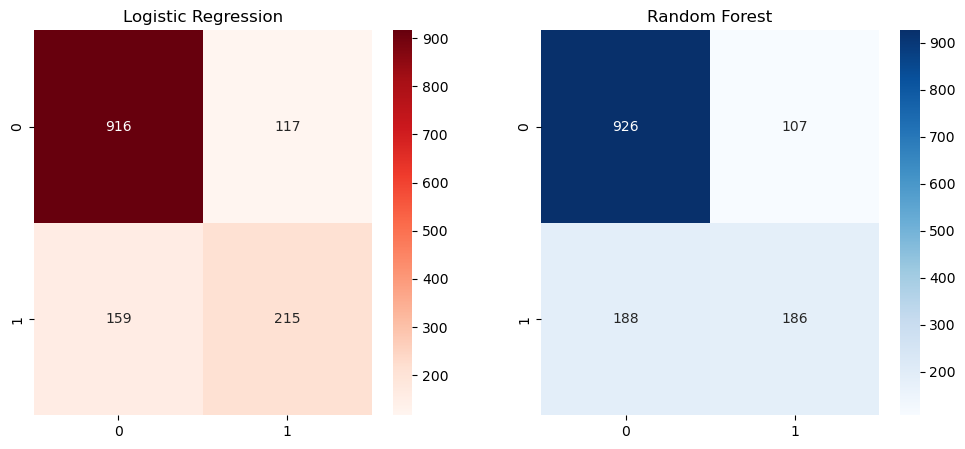

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', ax=ax[0], cmap='Reds')
ax[0].set_title('Logistic Regression')
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title('Random Forest')
plt.show()

Interpretation:

Both models are more likely to miss churners (high False Negatives compared to True Positives).

Logistic Regression catches more churners (TP=215 vs. 186) at the cost of more false positives.

Random Forest is slightly more conservative; better for non-churn but slightly worse for catching churn.

Model Evaluation & Interpretation
Both Logistic Regression and Random Forest achieved ~80% accuracy. Logistic Regression demonstrated a slightly better recall for predicting churn (0.57), meaning it correctly identified a larger fraction of customers who actually left compared to Random Forest (0.50).

The confusion matrix shows that most churners are not being detected (~43% recall missed). However, the models are very effective at predictably identifying customers who will not churn.

Model Evaluation & Interpretation
Both Logistic Regression and Random Forest achieved ~80% accuracy. Logistic Regression demonstrated a slightly better recall for predicting churn (0.57), meaning it correctly identified a larger fraction of customers who actually left compared to Random Forest (0.50).

The confusion matrix shows that most churners are not being detected (~43% recall missed). However, the models are very effective at predictably identifying customers who will not churn.

Key metrics:

Logistic Regression Accuracy: 80%, Churn Recall: 0.57
Random Forest Accuracy: 79%, Churn Recall: 0.50
These results provide a strong baseline for identifying at-risk customers, though further tuning is needed to raise recall and support business retention efforts.



Conclusion
Our models help identify customers likely to churn, enabling targeted interventions and retention campaigns. Going forward, model recall should be improved using advanced techniques and more feature engineering. The business should integrate this model into its CRM system and use periodic retraining for best results.

Business Interpretation
Recall is critical for churn prediction: identifying as many churners as possible helps reduce customer loss through targeted marketing or offers.

Both models have moderate recall for churn. Improving recall (even if precision drops) could improve retention programs.

The models perform well in identifying loyal customers, which can help focus resources on genuinely at-risk customers.

